#### Assignment on Text Analytics 

__Summary__: Apply text analytics to understand the relationship/similarity between companies based on their patents. The data is in 13 Excel files, one for each company to be used in the analysis. Each Excel file contains patents granted to the company in a particular year. The columns of relevance to are "TI" (the title of the patent) and "AB" (Abstract of the patent). The corpus we will use for analysis will contain 13 files, one for each company. Each file will contain the titles and abstracts of all the patents for that company.

Below steps are peformed:

a) Read each excel file and merge the TI and AB columns and write into individual text files

b) Preprocess the data and create a clean corpus:
   - Normalize the data by converting to lower case
   - Remove digits and punctuations
   - Remove the stop words
   - Perform lemmatization on the words in corpus 

c) Following unsupervised learning algorithms are performed on the data and result are compared: 
   - Multidimensional Scaling
   - Hierarchical Clustering
   - K-Means

d) Topic Modeling: 5 topics are obtained using three different algorithms and results are compared: 
   - NMF
   - LDA
   - LSA / LSI

__Note__: I specifically chose not to write functions for code reusability in this assignment, thus allowing me to write the code multiple times and practice more

 - Change the default file directory to the location where the dataset excel files are present

In [1]:
import os

os.chdir(r'C:\MSBA\Summer 2020\2205-INSY-5378-Data Science\Assignment 2\Patents_xls')

 - Get all the file names present in the folder with extension as .xlsx

In [2]:
import glob as glob

file_names_xlsx = glob.glob('*.xlsx')
print('file_names: ', file_names_xlsx) 

file_names:  ['Apple.xlsx', 'Google.xlsx', 'HTC.xlsx', 'Huawei.xlsx', 'InterDigital.xlsx', 'Kodak.xlsx', 'LG.xlsx', 'Nokia.xlsx', 'Oracle.xlsx', 'Pantech.xlsx', 'Samsung.xlsx', 'Sony Ericsson.xlsx', 'ZTE.xlsx']


Read each file from the folder into a DataFrame and perform below: 
 - Fill the Null values present in column 'TI' & 'AB' with blanks
 - Merge the columns TI and AB into one column. Create a new column (TI+AB) in the same dataframe
 - Convert the new column into a list and join all the words by separating with a space character and convert into a string
 - Write the string contents into respective .txt file
 
Note: utf-8 encoding is used as certain characters were not being mapped during file write

In [3]:
import pandas as pd 

for name in file_names_xlsx: 
    df = pd.read_excel(name)
    df[['TI','AB']] = df[['TI','AB']].fillna('') 
    df['TI+AB'] = df['TI'] + ' ' + df['AB']
    text = ' '.join(list(df['TI+AB'])) 
    filename = name.split('.')[0] + '.txt'
    with open(filename, 'w', encoding='utf-8') as outfile:
        outfile.write(text)

 - Get all the .txt file names present in the folder
 - Extract the list of firm names from above list 
 - Read each text file and append into the list of corpus

Note: Created corpus will be a list of text files: [file1, file2, file3, .., file13]

In [4]:
file_names_txt = glob.glob('*.txt')
firm_names = [name.split('.')[0] for name in file_names_txt]
print('firm_names:', firm_names) 

corpus_orig = []
for file_name in file_names_txt: 
    with open(file_name, 'r', encoding='utf-8') as infile: 
        corpus_orig.append(infile.read())

firm_names: ['Apple', 'Google', 'HTC', 'Huawei', 'InterDigital', 'Kodak', 'LG', 'Nokia', 'Oracle', 'Pantech', 'Samsung', 'Sony Ericsson', 'ZTE']


__Perform Pre-processing on the Corpus__

 - Normalize the words to lower case
 - Remove all the digits and punctuations from the corpus

In [5]:
import string

exclude_chars = string.digits + string.punctuation
table = str.maketrans(exclude_chars, len(exclude_chars) * ' ')
dig_pun_excl = [doc.lower().translate(table) for doc in corpus_orig]

Remove the stop words from corpus: 
 - English stopwords is imported from nltk module
 - For every document in the corpus, tokenize the document and check if each word is present in stopwords
 - If not present, then include in corpus
 - Merge the document words into a string and write into corpus for each file

In [6]:
import nltk

stop_words = nltk.corpus.stopwords.words('english')
stopwords_rem = [' '.join([word for word in doc.split() if word not in stop_words]) for doc in dig_pun_excl]

Lemmatize the words in the corpus: 
 - Load 'en_core_web_lg' from Spacy
 - Process every document in the corpus thru Spacy and lemmatize every token 
 - Merge the document words into a string and replace 'PRON' & '-PRON-' into blanks (Spacy replaces pronous with these lemmas)
 - Append the lemmatized string into a clean corpus for each document 

In [7]:
import spacy

nlp = spacy.load('en_core_web_lg')

# By default Spacy can process only 1,000,000 (1 Million) length of chars 
# 3 files (TI + AB columns alone) have length greater that this limit (LG: 2610889, Oracle: 1232277, Samsung: 5591467)
# Hence setting nlp.max_length variable to 6 Million 
nlp.max_length = 6000000

corpus = [' '.join([token.lemma_ for token in nlp(doc)]).replace('PRON','').replace('-PRON-','') for doc in stopwords_rem]

Convert the corpus into Document / Firm to Term Matrix using a TfidfVectorizer
 - We are considering only those words that have appeared atleast in two documents

Note: the DTM (Document/Firm to Term matrix) is displayed thru a dataframe for reference only. The firm names are used as index names and the columns is the list of words

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 2)
dtm_tfidf = vectorizer.fit_transform(corpus)
terms_tfidf = vectorizer.get_feature_names()

df_dtm = pd.DataFrame(dtm_tfidf.toarray(), columns = terms_tfidf, index = firm_names)
df_dtm

,aa,aaa,aal,ab,abandon,abbreviate,abbreviated,abbreviation,aberration,ability,...,zip,zirconium,zn,zno,zone,zoom,zooming,δt,δv,μm
Apple,0.000000,0.000398,0.000000,0.000970,0.000000,0.000000,0.000000,0.000547,0.001747,0.005343,...,0.000000,0.000000,0.000000,0.000000,0.002301,0.010068,0.000000,0.00000,0.000000,0.000000
Google,0.000000,0.000000,0.000000,0.000000,0.000000,0.000386,0.000000,0.000000,0.000000,0.001913,...,0.000435,0.000000,0.000000,0.000000,0.005950,0.002060,0.000000,0.00087,0.000870,0.000000
HTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Huawei,0.000000,0.006899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005215,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
InterDigital,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003284,0.000000,0.000000,0.00000,0.000000,0.000000
Kodak,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003296,0.000403,...,0.000000,0.000732,0.000000,0.000000,0.004341,0.017365,0.000000,0.00000,0.000000,0.000000
LG,0.000000,0.000000,0.001556,0.000000,0.000120,0.000425,0.000120,0.000598,0.000574,0.000234,...,0.000000,0.000106,0.000120,0.000838,0.004723,0.002456,0.000318,0.00012,0.000000,0.003351
Nokia,0.000762,0.000831,0.008757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001860,...,0.000000,0.000000,0.000000,0.000000,0.001202,0.004206,0.000000,0.00000,0.000000,0.000000
Oracle,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,0.000000,0.005082,...,0.003355,0.000000,0.000000,0.000000,0.010591,0.000530,0.001190,0.00000,0.000000,0.000000
Pantech,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.038391,0.000000,0.00000,0.000000,0.000000


 - Calculate Cosine similiarity using DTM and obtain the Cosine distances

Note: the Cosine distance is displayed thru a dataframe for reference only 

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(dtm_tfidf)
cos_distance = 1 - similarity

df_cos_distance = pd.DataFrame(cos_distance, columns = firm_names, index = firm_names)
df_cos_distance

,Apple,Google,HTC,Huawei,InterDigital,Kodak,LG,Nokia,Oracle,Pantech,Samsung,Sony Ericsson,ZTE
Apple,0.000000,0.115228,0.401928,0.336183,4.041840e-01,4.041465e-01,3.485487e-01,0.181515,0.225316,0.454992,3.200916e-01,2.061705e-01,4.402342e-01
Google,0.115228,0.000000,0.429530,0.262807,3.331451e-01,4.501665e-01,3.786484e-01,0.118016,0.201229,0.374166,3.546722e-01,2.075177e-01,3.897247e-01
HTC,0.401928,0.429530,0.000000,0.574305,6.051938e-01,6.224581e-01,5.331799e-01,0.426568,0.564777,0.573862,4.951251e-01,3.350856e-01,6.619026e-01
Huawei,0.336183,0.262807,0.574305,0.000000,4.204635e-01,6.289322e-01,4.590773e-01,0.174096,0.339692,0.446065,4.694525e-01,4.259379e-01,2.661310e-01
InterDigital,0.404184,0.333145,0.605194,0.420464,-2.220446e-16,7.027782e-01,5.367966e-01,0.286736,0.473143,0.438966,5.013322e-01,4.608346e-01,4.152356e-01
Kodak,0.404147,0.450166,0.622458,0.628932,7.027782e-01,-2.220446e-16,3.881172e-01,0.523659,0.589389,0.682185,3.279506e-01,5.148568e-01,7.113293e-01
LG,0.348549,0.378648,0.533180,0.459077,5.367966e-01,3.881172e-01,-2.220446e-16,0.387142,0.482855,0.492073,9.520825e-02,4.051494e-01,5.662180e-01
Nokia,0.181515,0.118016,0.426568,0.174096,2.867362e-01,5.236587e-01,3.871416e-01,0.000000,0.285396,0.302457,3.767517e-01,1.854401e-01,2.937364e-01
Oracle,0.225316,0.201229,0.564777,0.339692,4.731435e-01,5.893889e-01,4.828545e-01,0.285396,0.000000,0.569215,4.619384e-01,4.463533e-01,5.230350e-01
Pantech,0.454992,0.374166,0.573862,0.446065,4.389661e-01,6.821853e-01,4.920727e-01,0.302457,0.569215,0.000000,5.217475e-01,2.789431e-01,4.485917e-01


__Multi Dimensional Scaling (MDS):__
 - Plot the firm names on a 2 dimensional scatter plot using Multi Dimensional Scaling (MDS)
 - Pass the Cosine distances thru MDS fit_transform and retrieve the coordinates (X,Y)
 - Plot the respective coordinates for each firm on a scatter plot 

We see grouping of companies together and most of them making sense: 
 - South Korean companies - LG & Samsung - have similar product line ups
 - American companies (Apple, Google) & Scandinavian country competitor companies (Nokia & Sony Ericsson) are grouped together
 - Huawei & ZTE seem to be coming together

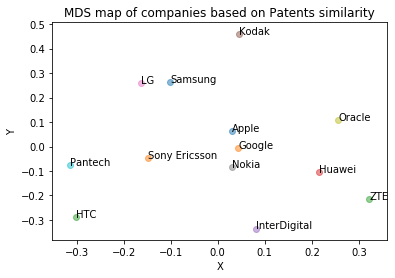

In [11]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 1)
pos = mds.fit_transform(cos_distance)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, firm_names):
    plt.scatter(x, y, alpha=0.5)
    plt.text(x, y, name)
    
plt.title('MDS map of companies based on Patents similarity')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

__Hierarchical clustering using Dendrogram:__

 - Import ward and dendrogram from scipy cluster hierarchy
 - Pass the Cosine distance to ward and obtain the linkage matrix
 - Pass the linakge matrix and firm names as labels to dendrogram and plot the chart from matplotlib pyplot
 
We notice below in Dendrogram: 
 - Samsung and LG grouped together
 - ZTE and Huawei grouped together
 - Google, Apple grouped together and inturn grouped along with Nokia, Sony Ericsson and Oracle
 - We also see Pantech grouped along with InterDigital
 
The clusters are similarly grouped as in MDS here as well. 

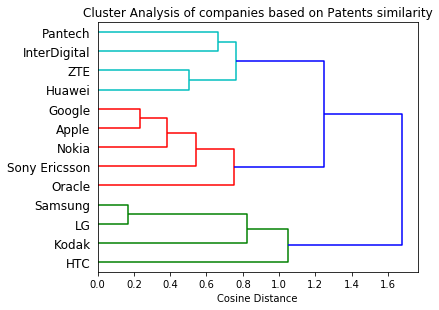

In [12]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(cos_distance)
dendrogram(linkage_matrix, orientation = 'right', labels = firm_names)
plt.tight_layout()
plt.title('Cluster Analysis of companies based on Patents similarity')
plt.xlabel('Cosine Distance')
plt.show()

__Non Hierarchical clustering using KMeans:__

 - Import KMeans from sklearn cluster
 - Pass the K value as 6 to KMeans algorithm 
 - Perform Fit, Predict and transform on the Firm to Term matrix obtained from TfidfCountvectorizer
 - Cluster membership from predict will have cluster assignments and firm distance to each cluster is in transform output
 - Display the cluster assignments by passing a dictionary with cluster membership, distance to each of clusters
 - The firm names will be the index of the dataframe and records are sorted based on clusters
 
We notice below in the clustering: 
 - Apple, Google, Nokia, Sony Ericsson and Oracle are grouped together
 - Huawei and ZTE are grouped together
 - LG and Samsung are grouped together
 - Pantech and InterDigital are grouped together
 
The results here as well are mostly similar to MDS and Hierarchical clustering. More understanding on the telecom domain and patents is required for better interpretation of the groupings.

In [13]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 6, random_state = 1)
cluster_solution = km.fit(dtm_tfidf)
cluster_membership = km.predict(dtm_tfidf)
dist_to_cluster = km.transform(dtm_tfidf)
 
cluster_dict = {'cluster_number': cluster_membership, 
                'dist_to_cluster_0': dist_to_cluster[:, 0], 
                'dist_to_cluster_1': dist_to_cluster[:, 1], 
                'dist_to_cluster_2': dist_to_cluster[:, 2], 
                'dist_to_cluster_3': dist_to_cluster[:, 3], 
                'dist_to_cluster_4': dist_to_cluster[:, 4], 
                'dist_to_cluster_5': dist_to_cluster[:, 5]
               }

df_clusters = pd.DataFrame(cluster_dict, index = firm_names) 
df_clusters.sort_values('cluster_number')

,cluster_number,dist_to_cluster_0,dist_to_cluster_1,dist_to_cluster_2,dist_to_cluster_3,dist_to_cluster_4,dist_to_cluster_5
Kodak,0,0.000000,1.098725,0.905048,0.817596,1.115758,1.079574
Huawei,1,1.121546,0.364781,0.664614,0.938576,1.071732,0.804392
ZTE,1,1.192753,0.364781,0.822204,1.040008,1.150567,0.802711
Apple,2,0.899051,0.802092,0.342808,0.788058,0.896581,0.799808
Google,2,0.948859,0.720740,0.288135,0.828080,0.926855,0.698447
Nokia,2,1.023385,0.578591,0.366568,0.846339,0.923654,0.608038
Oracle,2,1.085715,0.854202,0.538092,0.947201,1.062805,0.907125
Sony Ericsson,2,1.014748,0.877854,0.494387,0.861759,0.818640,0.721315
LG,3,0.881042,0.944579,0.791936,0.218184,1.032647,0.899659
Samsung,3,0.809877,0.948361,0.765271,0.218184,0.995113,0.896436


__Topic Modelling__

__1) Non-negative Matrix Factorization (NMF)__
 - Import decomposition from sklearn and numpy modules
 - We are chosing 5 topics (each containing 20 words) and pass the parameter to decompistion.NMF
 - Perform a fit_transform on the DTM obtained using TfidfCountvectorizer which results in the firm to topic matrix
 - For each of the topic retrieved from nmf.components_ :
   - Obtain the index of the top 20 words (as per score)
   - For each index, get the corresponding word from the feature / terms obtained from tfidf vectorizer 
   - Append all the words into the list of topics
 - Display the topics extracted from the corpus

In [14]:
from sklearn import decomposition
import numpy as np

num_topics = 5
num_top_words = 20

nmf = decomposition.NMF(n_components = num_topics, random_state = 1, max_iter=2000)
firm_topic_nmf = nmf.fit_transform(dtm_tfidf)

topic_words = []
for topic in nmf.components_:
    word_index = np.argsort(topic)[::-1][:num_top_words]
    topic_words.append([terms_tfidf[index] for index in word_index])

for i in range(len(topic_words)):
    print('Topic {}:\n{}\n'.format(i, ' '.join(topic_words[i])))
    
df_nmf_topics = pd.DataFrame(topic_words, index = ['Topic ' + str(i) for i in range(num_topics)]).T 
df_nmf_topics

Topic 0:
method datum device include user provide use network second information application object base receive determine set embodiment associate request store

Topic 1:
image electrode layer method include second device form display light substrate provide datum pixel apparatus liquid color organic gate use

Topic 2:
device second electronic unit remote connect host portable body plurality circuit include use antenna communication tone user board method surface

Topic 3:
communication mobile terminal signal method device receive information channel include datum unit wireless display data transmit control antenna base power

Topic 4:
method signal network service control invention packet communication present device gateway channel base wireless transmission message user transmit power terminal



,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,method,image,device,communication,method
1,datum,electrode,second,mobile,signal
2,device,layer,electronic,terminal,network
3,include,method,unit,signal,service
4,user,include,remote,method,control
5,provide,second,connect,device,invention
6,use,device,host,receive,packet
7,network,form,portable,information,communication
8,second,display,body,channel,present
9,information,light,plurality,include,device


Convert the corpus into Document / Firm to Term Matrix using CountVectorizer: 

 - We are considering only those words that have appeared atleast in two documents
 
Note: the DTM (Document/Firm to Term matrix) is displayed thru a dataframe for reference only. The firm names are used as index names and the columns is the list of words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cvectorizer = CountVectorizer(stop_words='english', min_df = 2)
dtm_cv = cvectorizer.fit_transform(corpus)
terms_cv = cvectorizer.get_feature_names()

df_dtm_cv = pd.DataFrame(dtm_cv.toarray(), columns = terms_cv, index = firm_names)
df_dtm_cv

,aa,aaa,aal,ab,abandon,abbreviate,abbreviated,abbreviation,aberration,ability,...,zip,zirconium,zn,zno,zone,zoom,zooming,δt,δv,μm
Apple,0,1,0,2,0,0,0,1,4,20,...,0,0,0,0,8,35,0,0,0,0
Google,0,0,0,0,0,1,0,0,0,9,...,1,0,0,0,26,9,0,2,2,0
HTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Huawei,0,8,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0
InterDigital,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
Kodak,0,0,0,0,0,0,0,0,5,1,...,0,1,0,0,10,40,0,0,0,0
LG,0,0,13,0,1,4,1,5,6,4,...,0,1,1,7,75,39,3,1,0,28
Nokia,2,3,23,0,0,0,0,0,0,10,...,0,0,0,0,6,21,0,0,0,0
Oracle,0,0,0,0,1,0,0,0,0,31,...,10,0,0,0,60,3,4,0,0,0
Pantech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0


__2) Latent Dirichlet Allocation (LDA)__
 - Import Latent Dirichlet Allocation from sklearn decomposition 
 - We are chosing 5 topics (each containing 20 words) and pass the parameter to LatentDirichletAllocation
 - Perform a fit_transform on the DTM obtained using CountVectorizer which results in the firm to topic matrix
 - For each of the topic retrieved from lda.components_ :
   - Obtain the index of the top 20 words (as per probability distribution score)
   - For each index, get the corresponding word from the feature / terms obtained from count vectorizer 
   - Append all the words into the list of topics
 - Display the topics extracted from the corpus

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = num_topics, random_state = 1, max_iter = 2000, learning_method = 'batch')
firm_topic_lda = lda.fit_transform(dtm_cv)

topic_words = []
for topic in lda.components_:
    words_index = np.argsort(topic)[::-1][:num_top_words]
    topic_words.append([terms_cv[index] for index in words_index])

for i in range(len(topic_words)):
    print('Topic {}: \n{}\n'.format(i,' '.join(topic_words[i])))
    
df_lda_topics = pd.DataFrame(topic_words, index = ['Topic ' + str(i) for i in range(num_topics)]).T
df_lda_topics

Topic 0: 
method include layer second device signal form electrode substrate display apparatus memory datum unit semiconductor use provide light line plurality

Topic 1: 
method datum include use provide user device second application base information set plurality server memory store associate object request receive

Topic 2: 
method include display device electrode layer datum second substrate form unit line liquid crystal information apparatus signal control provide use

Topic 3: 
image device method second include digital layer color light comprise provide pixel form capture material element use print display camera

Topic 4: 
device method communication network signal mobile receive terminal information wireless second user datum control transmit channel include service power base



,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,method,method,method,image,device
1,include,datum,include,device,method
2,layer,include,display,method,communication
3,second,use,device,second,network
4,device,provide,electrode,include,signal
5,signal,user,layer,digital,mobile
6,form,device,datum,layer,receive
7,electrode,second,second,color,terminal
8,substrate,application,substrate,light,information
9,display,base,form,comprise,wireless


__3) Latent Semantic Analysis / Indexing (LSA / LSI)__
 - Import Truncated SVD from sklearn decomposition 
 - We are chosing 5 topics (each containing 20 words) and pass the parameter to TruncatedSVD 
 - Perform a fit_transform on the DTM obtained using TfidfVectorizer which results in the firm to topic matrix
 - For each of the topic retrieved from lsa.components_ :
   - Obtain the index of the top 20 words (as per score)
   - For each index, get the corresponding word from the feature / terms obtained from Tfidf vectorizer 
   - Append all the words into the list of topics
 - Display the topics extracted from the corpus

In [17]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components = num_topics, random_state = 1, n_iter = 2000) 
firm_topic_lsa = lsa.fit_transform(dtm_tfidf)

topic_words = []
for topic in lsa.components_: 
    word_index = np.argsort(topic)[::-1][:num_top_words]
    topic_words.append([terms_tfidf[index] for index in word_index])

for i in range(len(topic_words)):
    print('Topic {}:\n{}\n'.format(i, ' '.join(topic_words[i])))
    
df_lsa_topics = pd.DataFrame(topic_words, index = ['Topic ' + str(i) for i in range(num_topics)]).T 
df_lsa_topics

Topic 0:
method device include signal communication datum second use network provide user information receive mobile control terminal unit base image display

Topic 1:
image electrode layer second light display form substrate include color liquid organic pixel device gate film material surface crystal emit

Topic 2:
electronic device mobile communication unit remote portable second terminal antenna connect host body hinge tone circuit handheld housing board slide

Topic 3:
application object user embodiment server provide use computer associate database datum device client electronic resource query interface plurality request node

Topic 4:
service network device connect remote invention gateway electronic packet present host unit forward tone control body optical board point method



,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,method,image,electronic,application,service
1,device,electrode,device,object,network
2,include,layer,mobile,user,device
3,signal,second,communication,embodiment,connect
4,communication,light,unit,server,remote
5,datum,display,remote,provide,invention
6,second,form,portable,use,gateway
7,use,substrate,second,computer,electronic
8,network,include,terminal,associate,packet
9,provide,color,antenna,database,present


Although the order of the topics and the words within each topic are different, the results of Topic modelling from the 3 algorithms (NMF, LDA and LSA) are almost similar. 

Note: LDA algorithm take the longest time to run compared to the other two (NMF and LSA).